In [1]:
# Add path
import sys
sys.path.insert(1, '../Scripts')

# Packages for Our filters
import measfilter as mf # package for measurement error filter
import gatesimu as gs # package for gate and measurment error filter
import expfuncs as ef

# Package for other Qiskit functions
from qiskit import Aer, IBMQ, QuantumCircuit, transpile, execute, QuantumRegister, ClassicalRegister
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

import csv


# Needed for functions
import numpy as np
import time
from copy import deepcopy
import pandas as pd

# Import Qiskit classes
import qiskit 
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

In [2]:
# Load Account and Choose Backend
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
name = 'ibmqx2' # ibmq_16_melbourne, ibmq_vigo, ibmq_london, ibmq_burlington, ibmq_essex, ibmqx2, ibmq_ourense
backend = provider.get_backend(name) 

In [3]:
interested_qubits = [2,1,0] # Descending order because Qiskit's readout is little-endian

itr = 32
shots = 8192
file_address = ''
#readout = mf.collect_filter_data(backend, itr=itr,shots=shots,if_monitor_job=True,if_write=True,file_address=file_address)

In [4]:
BJW_filter = mf.MeasFilter(interested_qubits, file_address=file_address)
#BJW_filter.inference(nPrior=40000, Priod_sd=0.1, seed=127, shots_per_point=1024)
BJW_filter.post_from_file() # if inference() is already run once

In [5]:
# meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1,2], circlabel='mcal')
# job = execute(meas_calibs, backend=backend,shots=8192,optimization_level=0)
# job_monitor(job)
cal_matrix = np.genfromtxt(file_address + 'cal_matrix1.csv', delimiter=',')
with open(file_address + 'state_labels1.csv', mode='r') as sgm:
    reader = csv.reader(sgm)
    state_labels = np.asarray([row for row in reader][0])

meas_filter = mc.MeasurementFilter(cal_matrix, state_labels)

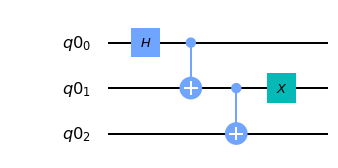

In [6]:
q5 = QuantumRegister(3)
bell5 = QuantumCircuit(q5)
bell5.h(q5[0])
for j in range(2):
    bell5.cx(q5[j], q5[j + 1])
bell5.x(q5[1])
bell5.draw(output = 'mpl')

In [16]:
# Get ideal output state
job = qiskit.execute(bell5, Aer.get_backend('statevector_simulator'))
psi_bell5 = job.result().get_statevector(bell5)
print(psi_bell5)
qst_bell5 = state_tomography_circuits(bell5, q5)

[0.        +0.j 0.        +0.j 0.70710678+0.j 0.        +0.j
 0.        +0.j 0.70710678+0.j 0.        +0.j 0.        +0.j]


In [8]:
job_tomo = qiskit.execute(qst_bell5, backend=backend, shots=8192)
job_monitor(job_tomo)

Job Status: job has successfully run


In [9]:
tomo_bell = StateTomographyFitter(job_tomo.result(), qst_bell5)
#no correction
rho_bell = tomo_bell.fit()
F_bell = state_fidelity(psi_bell5, rho_bell)
print('Fit Fidelity (no correction) =', F_bell)

Fit Fidelity (no correction) = 0.6718964152397564


In [10]:
#correct data
correct_tomo_results = meas_filter.apply(job_tomo.result(), method='least_squares')
tomo_bell = StateTomographyFitter(correct_tomo_results, qst_bell5)
rho_bell = tomo_bell.fit()
F_bell = state_fidelity(psi_bell5, rho_bell)
print('Qiskit: Fit Fidelity (w/ correction) =', F_bell)

Qiskit: Fit Fidelity (w/ correction) = 0.8970381799952865


In [11]:
our_filter = mc.MeasurementFilter(BJW_filter.mat_mean, state_labels)

In [12]:
#correct data
correct_tomo_results_BJW = our_filter.apply(job_tomo.result(), method='least_squares')
tomo_bell_BJW = StateTomographyFitter(correct_tomo_results_BJW, qst_bell5)
rho_bell_BJW = tomo_bell_BJW.fit()
F_bell_BJW = state_fidelity(psi_bell5, rho_bell_BJW)
print('BJW   : Fit Fidelity (w/ correction) =', F_bell_BJW)

BJW   : Fit Fidelity (w/ correction) = 0.9203350477340162


In [13]:
post_dict = {}
for q in interested_qubits:
    post_dict['Qubit{}'.format(q)] = pd.read_csv(
        file_address + 'StandPostQubit{}.csv'.format(q)).to_numpy()

stand_filter = ef.MeasFilterSB(interested_qubits, post_dict)
try:
    stand_filter.filter_mean(job_tomo)
except:
    pass
SB_filter = mc.MeasurementFilter(stand_filter.mat_mean, state_labels)

In [14]:
#correct data
correct_tomo_results_SB = SB_filter.apply(job_tomo.result(), method='least_squares')
tomo_bell_SB = StateTomographyFitter(correct_tomo_results_SB, qst_bell5)
rho_bell_SB = tomo_bell_SB.fit()
F_bell_SB = state_fidelity(psi_bell5, rho_bell_SB)
print('SB    : Fit Fidelity (w/ correction) =', F_bell_SB)

SB    : Fit Fidelity (w/ correction) = 0.9207427798172108


In [15]:
# import csv
# shots_per_point = 1024
# # Data for Standard Bayesian
# # Read data to for measurement error while input is |0>
# print('Write data for standard Bayesian')
# prop_dict = backend.properties().to_dict()
# with open(file_address + 'given_params.csv', mode='w', newline='') as sgm:
#     param_writer = csv.writer(sgm,
#                               delimiter=',',
#                               quotechar='"',
#                               quoting=csv.QUOTE_MINIMAL)
#     for q in interested_qubits:
#         p0m0 = 1 - prop_dict['qubits'][q][5]['value']
#         if p0m0 == 1 or p0m0 < 0.7:
#             p0m0 = 0.9
#         p1m1 = 1 - prop_dict['qubits'][q][4]['value']
#         if p1m1 == 1 or p1m1 < 0.7:
#             p1m1 = 0.9
#         param_writer.writerow([p0m0, p1m1])

# with open(file_address + 'Filter_data.csv', mode='r') as measfile:
#     reader = csv.reader(measfile)
#     cali01 = np.asarray([row for row in reader][0])

# Data = cali01
# for q in interested_qubits:
#     y = mf.getData0(Data, itr * int(8192 / shots_per_point), q)
#     with open(file_address + 'Qubit{}.csv'.format(q), mode='w',
#               newline='') as sgr:
#         read_writer = csv.writer(sgr,
#                                  delimiter=',',
#                                  quotechar='"',
#                                  quoting=csv.QUOTE_MINIMAL)
#         read_writer.writerow(['x', 'y'])
#         for i in range(len(y)):
#             read_writer.writerow([0.5, y[i]])